In [45]:
# Stiff Robertson's problem from chemical kinetics as in
# https://archimede.uniba.it/~testset/report/rober.pdf
import numpy as np
import matplotlib.pyplot as plt
import time
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Set the font family to serif
    "font.serif": ["Times New Roman"],  # Specify the serif font
    "font.size": 22,  # Set the default font size
})
a = 0.04
b = 1.0e4
c = 3.0e7



# the right-hand side
def func(y): 
    dy = np.zeros(3)
    byz = b*y[1]*y[2]
    cy2 = c*y[1]*y[1]
    ax = a*y[0]
    dy[0] = -ax + byz
    dy[1] = ax - byz - cy2
    dy[2] = cy2
    return dy

# the Jacobian matrix for the right-hand side
def Jac(y):
    by = b*y[1]
    bz = b*y[2]
    c2y = 2*c*y[1]
    Jac = np.zeros((3,3))
    Jac[0,0] = -a
    Jac[0,1] = bz
    Jac[0,2] = by
    Jac[1,0] = a
    Jac[1,1] = -bz-c2y
    Jac[1,2] = -by
    Jac[2,1] = c2y
    return Jac


In [67]:
class DIRK:
    def __init__(self,gamma,tol,itermax):
        self.tol = tol
        self.itermax = itermax
        self.gamma = gamma
    def newton_iter(self,y,h,k,gamma):
        aux = y + h*gamma*k
        F = k - self.func(aux)
        DF = np.identity(len(y)) - h*gamma*self.jac(aux)
        return k - np.linalg.solve(DF,F)

    def dirk2_step(self,y,h):
        k1 = self.func(y)
        gamma = self.gamma
        for j in range(self.itermax):
            k1 = self.newton_iter(y,h,k1,gamma)
            if np.linalg.norm(k1 - self.func(y + h*self.gamma*k1)) < self.tol:
                break
        # print( np.linalg.norm(k1 - func(y + h*gamma*k1)))
        # print(j)
        k2 = k1
        y = y + h*(1-self.gamma)*k1
        for j in range(self.itermax):
            k2 = self.newton_iter(y,h,k2,gamma)
            aux = y + h*self.gamma*k2
            if np.linalg.norm(k2 - self.func(aux)) < self.tol:
                break
        # print( np.linalg.norm(k2 - func(aux)))
        # print(j)
        return aux

    def setup(self,func,jac):
        self.func = func
        self.jac = jac

    def solve(self,func,jac,y0,h,t_max):
        self.setup(func,jac)
        self.y0 = y0
        self.h = h
        self.rtol = 1e-5
        nsteps = int(np.ceil(t_max/h))
        sol = np.zeros((nsteps+1,len(y0)))
        t = np.arange(0,(nsteps+1)*h,h)
        sol[0,:] = y0
        for j in range(nsteps): # DIRK2
            sol[j+1,:] = self.dirk2_step(sol[j,:],self.h)
        return sol,t
    def adaptive_solve(self, func, jac, y0, h, t_max, atol=1e-5, rtol=1e-5):
        self.setup(func, jac)
        self.y0 = y0
        t = 0
        sol = [y0]
        times = [t]
        self.h = h
        while t < t_max:
            y_current = sol[-1]
            y_next = self.dirk2_step(y_current, self.h)

            # Error estimation
            y_next_half = self.dirk2_step(y_current, self.h / 2)
            y_next_half = self.dirk2_step(y_next_half, self.h / 2)

            error = np.linalg.norm(y_next_half - y_next)
            norm_y = np.linalg.norm(y_next)
            tol = atol + rtol * norm_y

            if error < tol:
                # Accept the step
                sol.append(y_next)
                t += self.h
                times.append(t)
                # Increase time step
                self.h *= 1.5
            else:
                # Decrease time step
                self.h *= 0.5

        return np.array(sol), np.array(times)


class DIRK2(DIRK):
    def __init__(self,tol=1e-14,itermax=20,):
        super().__init__(gamma=1.0 - 1.0/np.sqrt(2),tol=tol,itermax=itermax,)


class DIRKf:
    def __init__(self, gamma, tol, itermax):
        self.gamma = gamma
        self.tol = tol
        self.itermax = itermax
    
    def newton_iter(self, y, h, k, gamma):
        aux = y + h * gamma * k
        F = k - self.func(aux)
        DF = np.identity(len(y)) - h * gamma * self.jac(aux)
        return k - np.linalg.solve(DF, F)
    
    def dirkf_step(self, y, h):
        gamma = self.gamma
        k1 = self.func(y)
        
        for _ in range(self.itermax):
            k1 = self.newton_iter(y, h, k1, gamma)
            if np.linalg.norm(k1 - self.func(y + h * gamma * k1)) < self.tol:
                break
        
        k2 = k1
        y = y + h*(1-2*gamma)*k1
        for _ in range(self.itermax):
            k2 = self.newton_iter(y, h, k2, gamma)
            # aux = y + h * ((1 - 2 * gamma) * k1 + gamma * k2)
            aux = y + h * (gamma * k2)
            if np.linalg.norm(k2 - self.func(aux)) < self.tol:
                break
        
        return aux
    
    def setup(self,func,jac):
        self.func = func
        self.jac = jac

    def solve(self, func, jac, y0, h, t_max):
        self.setup(func,jac)
        nsteps = int(np.ceil(t_max / h))
        sol = np.zeros((nsteps + 1, len(y0)))
        t = np.arange(0, (nsteps + 1) * h, h)
        sol[0, :] = y0
        
        for j in range(nsteps):
            sol[j + 1, :] = self.dirkf_step(sol[j, :], h)
        
        return sol, t

class DIRK3(DIRKf):
    def __init__(self, tol=1e-14, itermax=20):
        super().__init__(gamma=1/2 + np.sqrt(3)/6, tol=tol, itermax=itermax)

import numpy as np

class BDF2:
    def __init__(self, tol=1e-14, itermax=20):
        self.tol = tol
        self.itermax = itermax
    
    def newton_iter(self, y, y_prev, h, k, func, jac):
        aux = (4/3) * y - (1/3) * y_prev + (2/3) * h * k
        F = k - func(aux)
        DF = np.identity(len(y)) - (2/3) * h * jac(aux)
        return k - np.linalg.solve(DF, F)
    
    def bdf2_step(self, y_prev, y, h, func, jac):
        k = func(y)
        for _ in range(self.itermax):
            k_new = self.newton_iter(y, y_prev, h, k, func, jac)
            if np.linalg.norm(k_new - k) < self.tol:
                break
            k = k_new
        return (4/3) * y - (1/3) * y_prev + (2/3) * h * k
    
    def solve(self, func, jac, y0, h, t_max):
        dirk2 = DIRK2(tol=self.tol, itermax=self.itermax)
        nsteps = int(np.ceil(t_max / h))
        
        sol = np.zeros((nsteps + 1, len(y0)))
        t = np.arange(0, (nsteps + 1) * h, h)
        
        sol[0, :] = y0
        dirk2.setup(func,jac)
        sol[1, :] = dirk2.dirk2_step(y0, h)  # First step using DIRK2
        
        for j in range(1, nsteps):
            sol[j + 1, :] = self.bdf2_step(sol[j - 1, :], sol[j, :], h, func, jac)
        
        return sol, t


DIRK2 took 2.3673348426818848 seconds
DIRK3 took 2.3483121395111084 seconds
BDF2 took 2.259491443634033 seconds


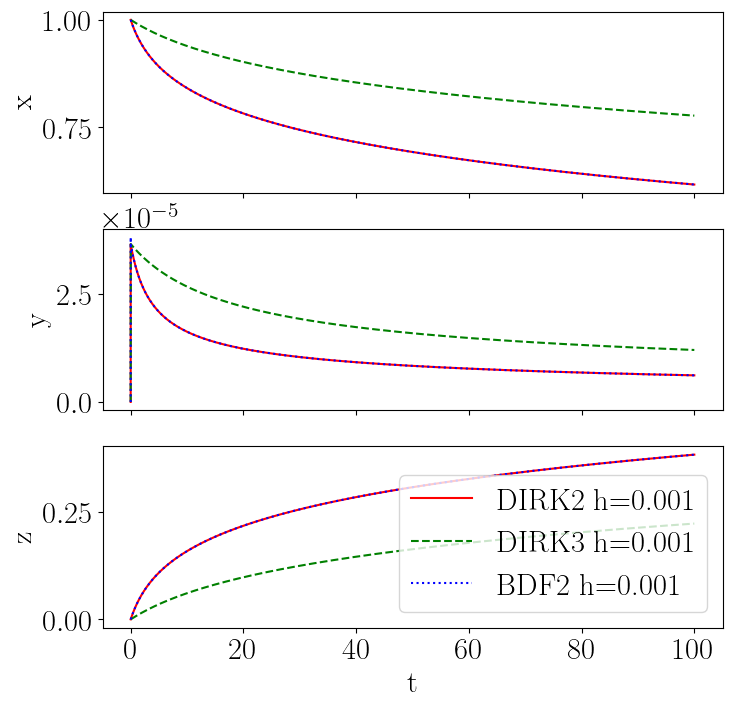

DIRK2 took 0.24708294868469238 seconds
DIRK3 took 0.30554795265197754 seconds
BDF2 took 0.22876286506652832 seconds


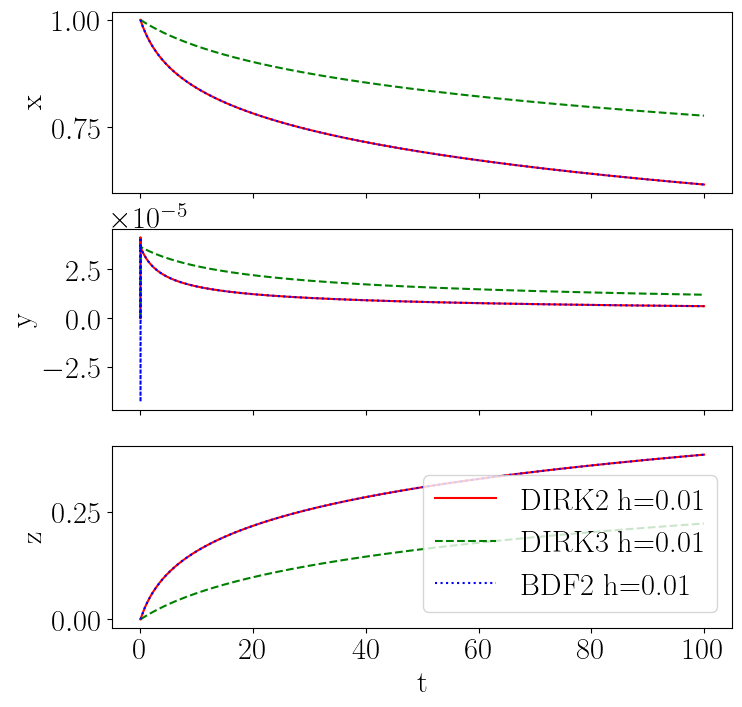

DIRK2 took 0.03231930732727051 seconds
DIRK3 took 0.04410099983215332 seconds
BDF2 took 0.025637388229370117 seconds


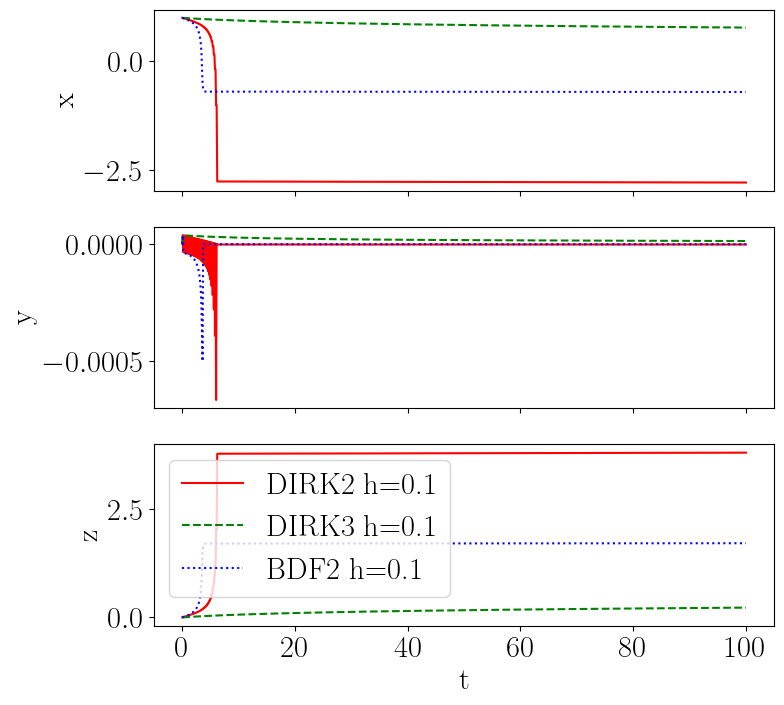

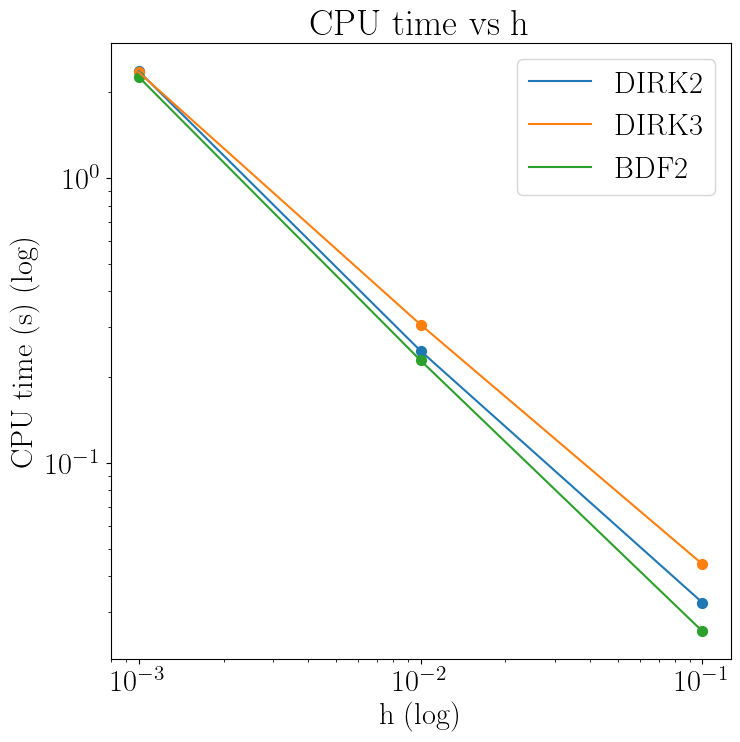

In [54]:
def run_plot_method(method_clss,method_names):
    # h = 1.0e-1
    Tmax = 1.0e2 # up to 4.0e10
    
    tol = 1.0e-14
    itermax = 40

    y0 = np.array([1.0,0.0,0.0])
    colors = ['red','green','blue']
    styles = ['-','--',':']
    times = {}
    for h in [1e-3,1e-2,1e-1]:
        fig, axs = plt.subplots(3,1,figsize = (8,8), sharex=True)
        times[h] = {}
        for i,(method_cls,method_name) in enumerate(zip(method_clss,method_names)):
            

            Nsteps = int(np.ceil(Tmax/h))
            before = time.time()
            sol,t = method_cls(tol=tol,itermax=itermax).solve(func=func,jac=Jac,y0=y0,h=h,t_max=Tmax,)
            after = time.time()
            times[h][method_name] = after-before
            print(f"{method_name} took {after-before} seconds")
            plt.rcParams.update({'font.size': 22})
            axs[0].plot(t,sol[:,0],label = f"{method_name} h={h}",c=colors[i],linestyle=styles[i])
            # axs[0].set_xlabel("t")
            axs[0].set_ylabel("x")
            # axs[0].legend()
            #plt.xscale("log")
            axs[1].plot(t,sol[:,1],label = f"{method_name} h={h}",linestyle=styles[i],c=colors[i])
            # axs[1].set_xlabel("t")
            axs[1].set_ylabel("y")
            # axs[0].legend()
            #plt.xscale("log")
            axs[2].plot(t,sol[:,2],label = f"{method_name} h={h}",linestyle=styles[i],c=colors[i])
            axs[2].set_xlabel("t")
            axs[2].set_ylabel("z")
            plt.legend()
        plt.show()
    x = [h for h in times]
    # y = [[times[h][method_name] for method_name in times[h]] for h in times]
    fig, axs = plt.subplots(1,1,figsize = (8,8))
    axs.set_title("CPU time vs h")
    for method_name in times[x[0]]:
        y = [times[h][method_name] for h in x]
        axs.plot(x,y,label = method_name)
        # axs.plot(x,y)
        axs.scatter(x,y, s=50,)  # Thick points
        axs.set_xlabel("h (log)")
        axs.set_ylabel("CPU time (s) (log)")
        axs.set_xscale("log")
        axs.set_yscale("log")
    plt.legend()
    plt.show()

run_plot_method([DIRK2,DIRK3,BDF2],["DIRK2","DIRK3","BDF2"])

In [70]:
def van_der_pol(y,mu=1):
    return np.array([y[1], mu*(1 - y[0]**2)*y[1] - y[0]])

def Jac(y, mu=1):
    y0, y1 = y
    J = np.array([[0, 1],
                  [-2 * mu * y0 * y1 - 1, mu * (1 - y0**2)]])
    return J

100.0,DIRK2: 8.45273232460022


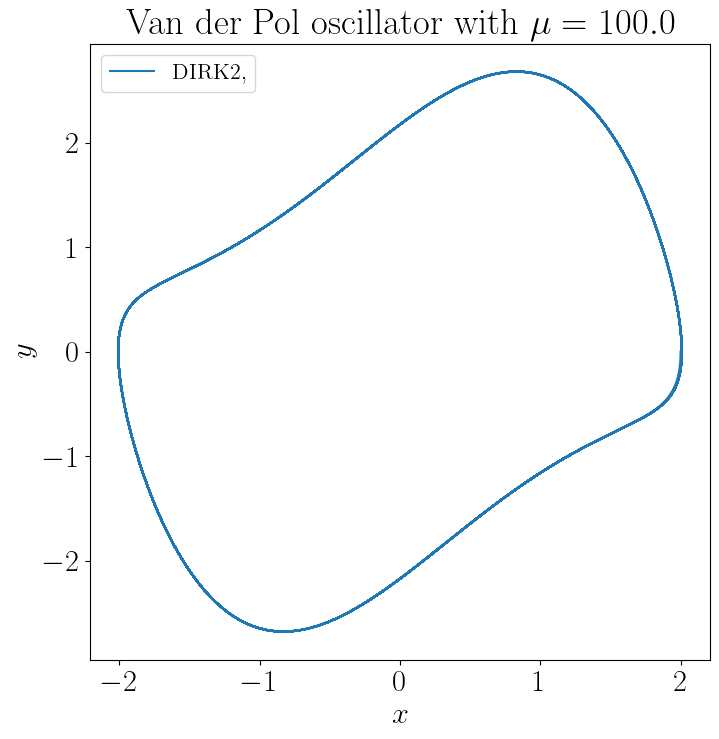

1000.0,DIRK2: 8.361243724822998


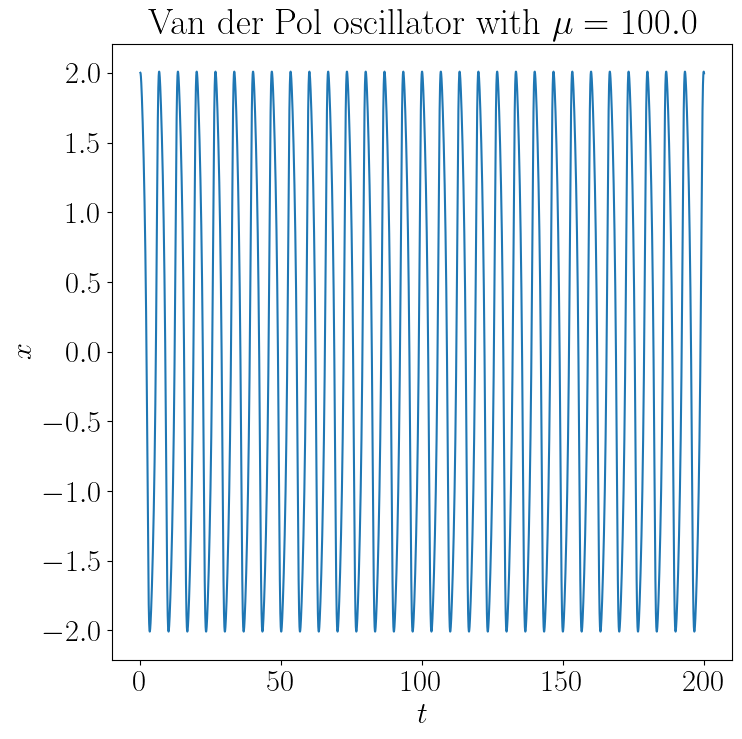

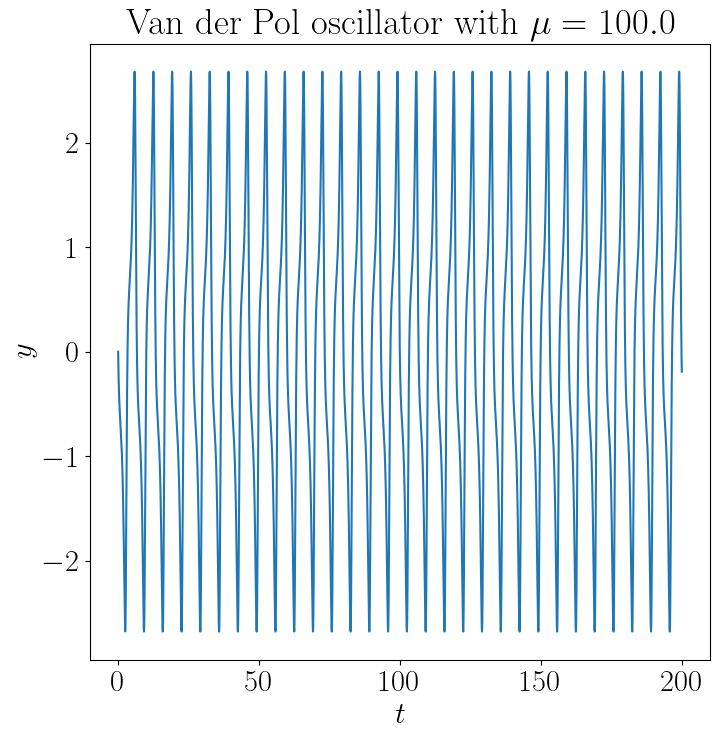

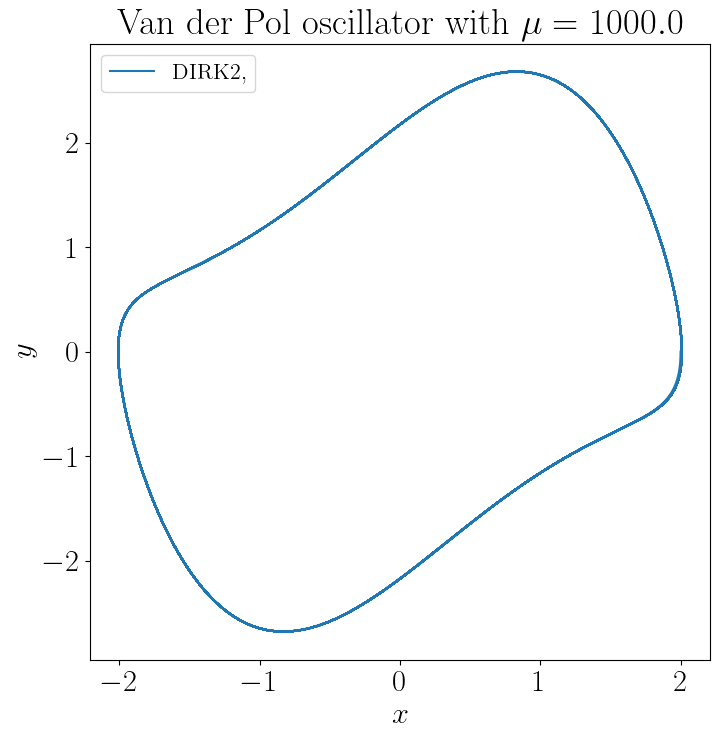

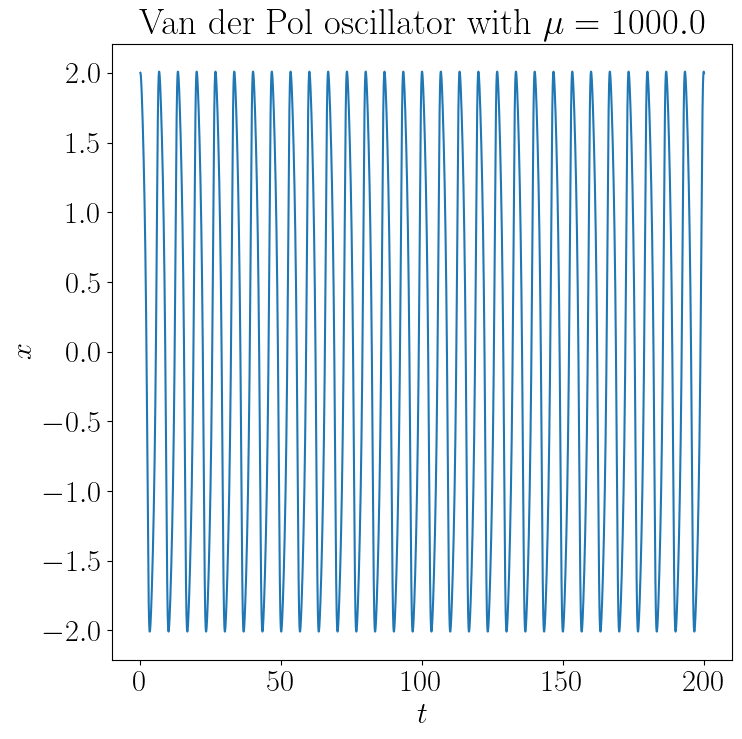

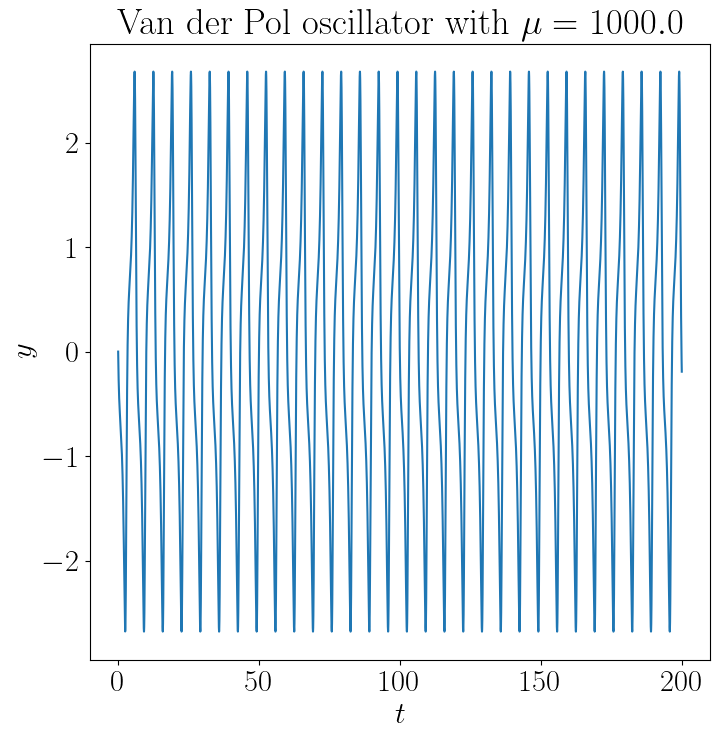

In [43]:
tmax=200.0
times = {}
method = 'DIRK2'
for mu in [1e2,1e3]:
    fig,ax = plt.subplots(figsize=(8,8))
    plt.title(f'Van der Pol oscillator with $\mu = {mu}$')
    start_time = time.time()
    y0 = np.array([2.0,0.0])
    h = 1e-3
    # sol = solve_ivp(van_der_pol,[0,tmax],[2,0],args=(mu,),method=method,rtol=eps,atol=eps)
    sol,t = DIRK2(tol=1e-14,itermax=20).solve(func=van_der_pol,jac=Jac,y0=y0,h=h,t_max=tmax)
    end_time = time.time()
    times[mu] = end_time-start_time
    print(f'{mu},{method}: {end_time-start_time}')
    ax.plot(sol[:,0], sol[:,1], label=f'{method},')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
            # plt.plot(sol.t, sol.y[0])
            # print(np.min(sol.y))
    plt.legend(loc='upper left',fontsize=16)
    plt.show()

    fig,ax = plt.subplots(figsize=(8,8))
    plt.title(f'Van der Pol oscillator with $\mu = {mu}$')
    ax.plot(t, sol[:,0], label=f'{method},')
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    fig,ax = plt.subplots(figsize=(8,8))
    plt.title(f'Van der Pol oscillator with $\mu = {mu}$')
    ax.plot(t, sol[:,1], label=f'{method},')
    ax.set_xlabel('$t$')
    ax.set_ylabel('$y$')

1000000.0,DIRK2: 2.2509868144989014


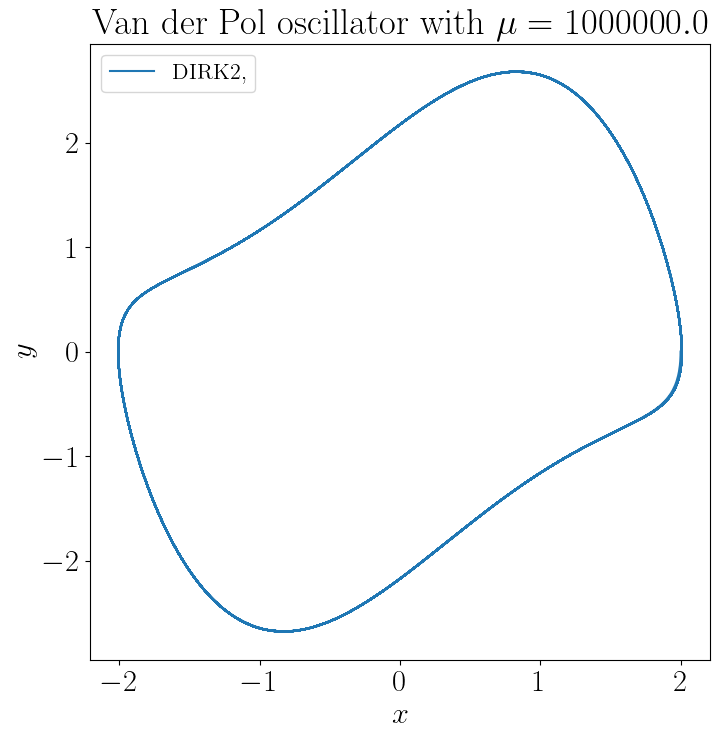

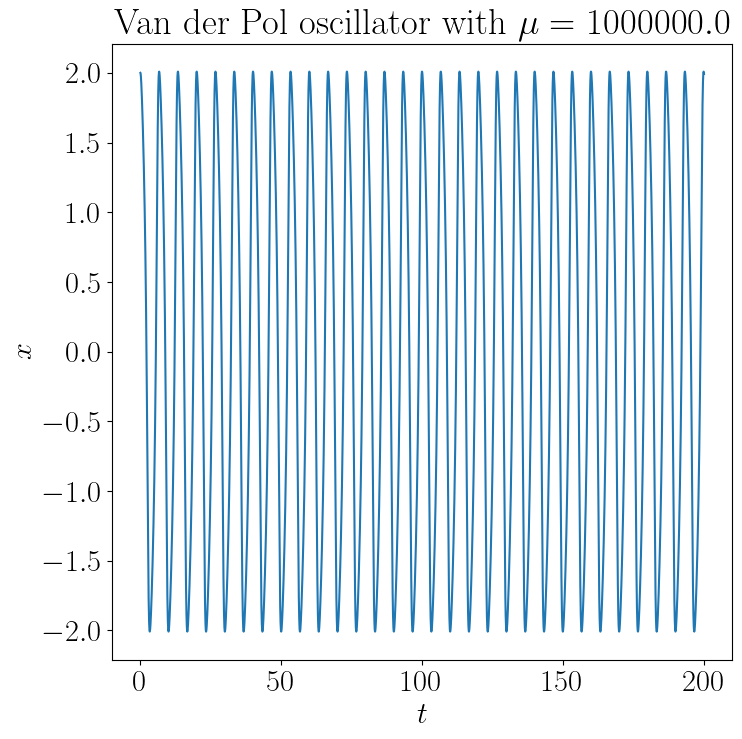

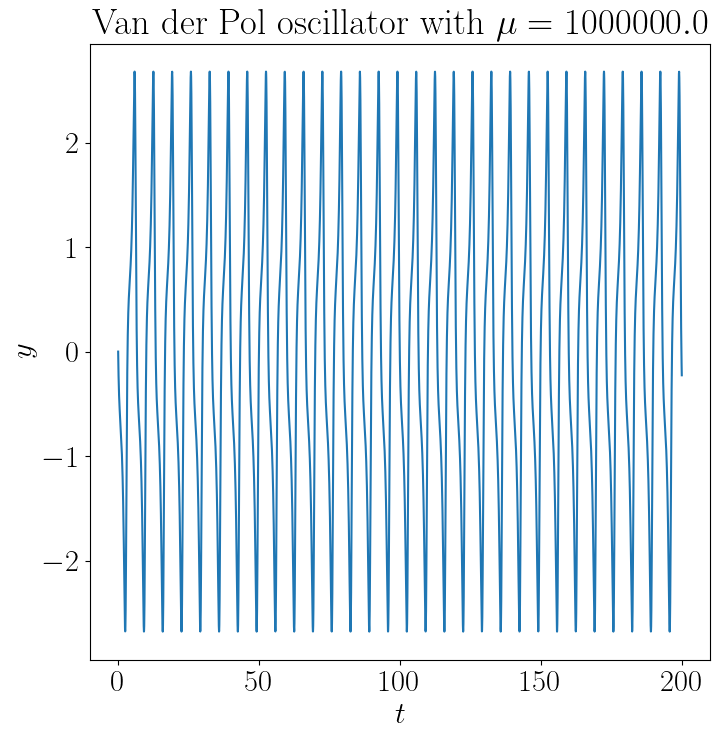

: 

In [ ]:
tmax=200.0
times = {}
method = 'DIRK2'
for mu in [1e6]:
    fig,ax = plt.subplots(figsize=(8,8))
    plt.title(f'Van der Pol oscillator with $\mu = {mu}$')
    start_time = time.time()
    y0 = np.array([2.0,0.0])
    h = 1e-3
    # sol = solve_ivp(van_der_pol,[0,tmax],[2,0],args=(mu,),method=method,rtol=eps,atol=eps)
    sol,t = DIRK2(tol=1e-14,itermax=20).adaptive_solve(func=van_der_pol,jac=Jac,y0=y0,h=h,t_max=tmax)
    end_time = time.time()
    times[mu] = end_time-start_time
    print(f'{mu},{method}: {end_time-start_time}')
    ax.plot(sol[:,0], sol[:,1], label=f'{method},')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
            # plt.plot(sol.t, sol.y[0])
            # print(np.min(sol.y))
    plt.legend(loc='upper left',fontsize=16)
    plt.show()

    fig,ax = plt.subplots(figsize=(8,8))
    plt.title(f'Van der Pol oscillator with $\mu = {mu}$')
    ax.plot(t, sol[:,0], label=f'{method},')
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    fig,ax = plt.subplots(figsize=(8,8))
    plt.title(f'Van der Pol oscillator with $\mu = {mu}$')
    ax.plot(t, sol[:,1], label=f'{method},')
    ax.set_xlabel('$t$')
    ax.set_ylabel('$y$')